In [1]:
# IMAGE CONFIGURATIONS
# The original size of images are (600, 800). We'll take 512 x 512, which are both smaller than original size: act as a form of data augmentation
IMAGE_SIZE = [512, 512] 

# TRAINING CONFIGURATIONS
epochs = 16
batch_size = 128

## Preparing Data

In [2]:
import pandas as pd
df_train_data = pd.read_csv('cassava-leaf-disease-classification/train.csv')
df_train_data

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


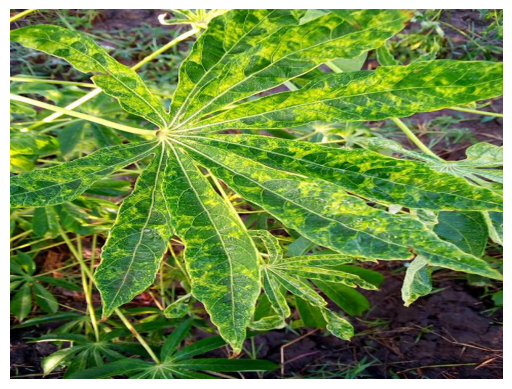

In [3]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from torchvision import transforms

# Define the path to your train_images directory
train_path = 'cassava-leaf-disease-classification/train_images'

# Use glob to get all image files with .jpg or .jpeg extensions
image_files = glob(train_path + '/*.jp*g')

# Define the transformation (ToTensor)
transform = transforms.ToTensor()

# Randomly select an image path
img_path = np.random.choice(image_files)

# Open the image
image = Image.open(img_path)

# Apply the transform to convert the image to a tensor
image_tensor = transform(image)

# Display the image
plt.imshow(image_tensor.permute(1, 2, 0))  # Permute is needed to change the shape to (H, W, C)
plt.axis('off')  # Hide axis
plt.show()

In [4]:
unique_labels = df_train_data.label.value_counts()
num_unique_labels = unique_labels.nunique()


In [5]:
from sklearn import model_selection
df_train, df_valid = model_selection.train_test_split(df_train_data, test_size=0.1, random_state=109, stratify=df_train_data["label"].values)
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [6]:
from torch.utils.data import Dataset
import os 
import cv2
class ConstDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(train_path, file_name)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
proc_resize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = IMAGE_SIZE)
        ])
train_df = ConstDataset(df_train, transform=proc_resize)

In [8]:
import torch 
trainloader = torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0)

In [9]:
from tqdm import tqdm
def calc_mean_std(train_df, trainloader): 
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])
    
    for input_image,_ in tqdm(trainloader):
        psum    += input_image.sum(axis        = [0, 2, 3])
        psum_sq += (input_image ** 2).sum(axis = [0, 2, 3])

    count = len(train_df) * IMAGE_SIZE[0] * IMAGE_SIZE[1]   
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    mean = total_mean.numpy()
    std = total_std.numpy()
    return (mean, std)
calc_mean, calc_std = calc_mean_std(train_df, trainloader)

100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [09:53<00:00,  3.93s/it]


In [10]:
proc_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = IMAGE_SIZE),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=calc_mean,std=calc_std)
])
train_df = ConstDataset(df_train, transform=proc_aug)
valid_df = ConstDataset(df_valid, transform=proc_aug)

In [12]:
dataloader = {'train': torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0), 
              'val': torch.utils.data.DataLoader(valid_df, batch_size,
                                          shuffle=True, num_workers=0)}

## Training model

In [13]:
resnext = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)

Using cache found in C:\Users\jingh/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\jingh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jingh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
resnext.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [15]:
import torch.nn as nn
import torch.optim as optim

#set the number of classes for resnet18 model classification layer
num_classes = 5
# The input to the fully connected layer is resnet18.fc.in_features
resnext.fc = nn.Linear(resnext.fc.in_features, num_classes)

In [16]:
for name, param in resnext.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnext.parameters(), lr=0.0001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnext = resnext.to(device)

In [18]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            resnext.train()
        else:
            resnext.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = resnext(inputs)  
            with torch.set_grad_enabled(phase == 'train'):
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        if phase == 'train': 
            epoch_loss = running_loss / len(train_df)
            epoch_acc = running_corrects.double() / len(train_df)
        else: 
            epoch_loss = running_loss / len(valid_df)
            epoch_acc = running_corrects.double() / len(valid_df)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

KeyboardInterrupt: 